# Covid Act Now Data Exploration
from covidactnow.org FAQ:
> Our data comes from official sources including the U.S. Department of Health and Human Services, the Centers for Disease Control and Prevention, The New York Times, and official state and county dashboards.

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import os

%matplotlib inline

In [2]:
path = '../../data/CANdata/counties.timeseries.csv'

In [3]:
candata_raw = pd.read_csv(path, parse_dates=['date'])

## Understand & Refine covidactnow.org Data

In [4]:
candata_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1885513 entries, 0 to 1885512
Data columns (total 40 columns):
 #   Column                                  Dtype         
---  ------                                  -----         
 0   date                                    datetime64[ns]
 1   country                                 object        
 2   state                                   object        
 3   county                                  object        
 4   fips                                    int64         
 5   lat                                     float64       
 6   long                                    float64       
 7   locationId                              object        
 8   actuals.cases                           float64       
 9   actuals.deaths                          float64       
 10  actuals.positiveTests                   float64       
 11  actuals.negativeTests                   float64       
 12  actuals.contactTracers                  fl

In [5]:
# Lot of interesting columns, what percentage of their data is filled in?
((~candata_raw.isna()).sum() / candata_raw.shape[0]) * 100

# Note: the vaccination data is unnaturally empty as vaccines were not widely available until spring '21

date                                      100.000000
country                                   100.000000
state                                     100.000000
county                                    100.000000
fips                                      100.000000
lat                                         0.000000
long                                        0.000000
locationId                                100.000000
actuals.cases                              86.196117
actuals.deaths                             83.896054
actuals.positiveTests                       0.028586
actuals.negativeTests                       0.028745
actuals.contactTracers                      0.025457
actuals.hospitalBeds.capacity               0.000000
actuals.hospitalBeds.currentUsageTotal      8.772785
actuals.hospitalBeds.currentUsageCovid      8.236750
actuals.hospitalBeds.typicalUsageRate       0.000000
actuals.icuBeds.capacity                    5.742840
actuals.icuBeds.currentUsageTotal           5.

In [6]:
candata_raw.head(10)

# Looks like this is grouped and ordered by state, county, and then date

,date,country,state,county,fips,lat,long,locationId,actuals.cases,actuals.deaths,...,metrics.infectionRateCI90,metrics.icuHeadroomRatio,metrics.icuHeadroomDetails,metrics.icuCapacityRatio,riskLevels.overall,metrics.vaccinationsInitiatedRatio,metrics.vaccinationsCompletedRatio,actuals.newDeaths,actuals.vaccinesAdministered,riskLevels.caseDensity
0,2020-01-22,US,AK,Aleutians East Borough,2013,NaN,NaN,iso1:us#iso2:us-ak#fips:02013,NaN,NaN,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0
1,2020-01-23,US,AK,Aleutians East Borough,2013,NaN,NaN,iso1:us#iso2:us-ak#fips:02013,NaN,NaN,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0
2,2020-01-24,US,AK,Aleutians East Borough,2013,NaN,NaN,iso1:us#iso2:us-ak#fips:02013,NaN,NaN,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0
3,2020-01-25,US,AK,Aleutians East Borough,2013,NaN,NaN,iso1:us#iso2:us-ak#fips:02013,NaN,NaN,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0
4,2020-01-26,US,AK,Aleutians East Borough,2013,NaN,NaN,iso1:us#iso2:us-ak#fips:02013,NaN,NaN,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0
5,2020-01-27,US,AK,Aleutians East Borough,2013,NaN,NaN,iso1:us#iso2:us-ak#fips:02013,NaN,NaN,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0
6,2020-01-28,US,AK,Aleutians East Borough,2013,NaN,NaN,iso1:us#iso2:us-ak#fips:02013,NaN,NaN,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0
7,2020-01-29,US,AK,Aleutians East Borough,2013,NaN,NaN,iso1:us#iso2:us-ak#fips:02013,NaN,NaN,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0
8,2020-01-30,US,AK,Aleutians East Borough,2013,NaN,NaN,iso1:us#iso2:us-ak#fips:02013,NaN,NaN,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0
9,2020-01-31,US,AK,Aleutians East Borough,2013,NaN,NaN,iso1:us#iso2:us-ak#fips:02013,NaN,NaN,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0


In [7]:
# Out of curiousity, are there latitude and logitude data
print('latitude values: ', candata_raw['lat'].value_counts())
print('longitude values: ', candata_raw['long'].value_counts())

# All latitude and longitude values are NaN

latitude values:  Series([], Name: lat, dtype: int64)
longitude values:  Series([], Name: long, dtype: int64)


In [8]:
# Just to make sure I understand, is actuals.death a cumulative total?
# We'll look at a random county's actuals.death values (again, assuming ordered by date)
candata_raw[(candata_raw['state']=='VA') & (candata_raw['county']=='Albemarle County')]['actuals.deaths'].to_numpy()

# yep, cumulative

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
        4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
        4.,  4.,  4.,  4.,  4.,  5.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        8.,  8.,  8.,  8.,  8.,  9.,  9.,  9.,  9.,  9.,  9., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10

In [9]:
# Sanity checks: Total US cases & deaths?
worldometer_cases = 40513018
our_cases = candata_raw.groupby('fips')['actuals.cases'].max().sum()

worldometer_deaths = 662853
our_deaths = candata_raw.groupby('fips')['actuals.deaths'].max().sum()

print('cases total:', int(our_cases), '-->', f'{(our_cases - worldometer_cases)/worldometer_cases:.1%}')
print('death total:', int(our_deaths), '-->', f'{(our_deaths - worldometer_deaths)/worldometer_deaths:.1%}')

# Our totals are a little less than the most generous estimate I've seen (worldometers.info), comfortable territory for me.

cases total: 39235438 --> -3.2%
death total: 629351 --> -5.1%


In [10]:
# What's the difference between actuals.cases and actuals.positiveTests
empty_cases = candata_raw['actuals.cases'].isna().sum()
empty_positiveTests = candata_raw['actuals.positiveTests'].isna().sum()

print('cases NaNs:', empty_cases, '-->', f'{empty_cases/candata_raw.shape[0]:.1%}')
print('postive tests NaNs:', empty_positiveTests, '-->', f'{empty_positiveTests/candata_raw.shape[0]:.1%}')

# Ah, positive tests data is empty

cases NaNs: 260274 --> 13.8%
postive tests NaNs: 1884974 --> 100.0%


In [11]:
# Columns with insufficient data are not included. Note vaccination data inclusion seems low (<40%), but it did not exist until late 2020
columns = ['date', 'state', 'county', 'fips', 'actuals.cases', 'actuals.newCases', 'actuals.deaths', 'actuals.newDeaths', 'metrics.vaccinationsCompletedRatio', 'metrics.testPositivityRatio', 'metrics.infectionRate']
candata = candata_raw[columns]

In [12]:
# And to improve readability, shorten names
candata.columns = ['date', 'state', 'county', 'fips', 'cases_total', 'cases_new', 'deaths_total', 'deaths_new', 'vaccination_rate', 'test_positivity', 'infection_rate']

In [13]:
# Turn fips into string wtih 5 digits for easy merging with counties data
candata['fips'] = candata['fips'].astype(str).str.zfill(5)

<ipython-input-13-60b5e66f445a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candata['fips'] = candata['fips'].astype(str).str.zfill(5)


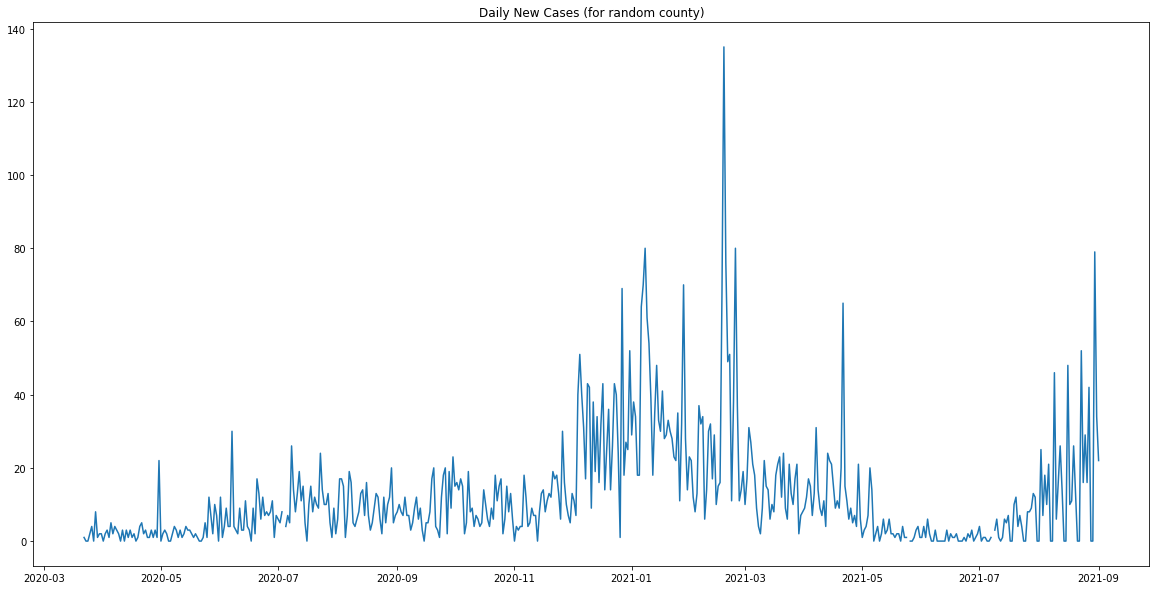

In [14]:
# We want to know if each county's response time to the largest Covid 19 wave of outbreaks predicts it's case count
albemarle = candata[(candata['state']=='VA') & (candata['county']=='Albemarle County')]
plt.figure(figsize=(20,10))
plt.title('Daily New Cases (for random county)')
plt.plot(albemarle['date'], albemarle['cases_new'])

# The peak value of the simple plot of each day's new case count doesn't work 
# because it is too vulnerable to outlier and "catch up" reporting... like that spike in late February

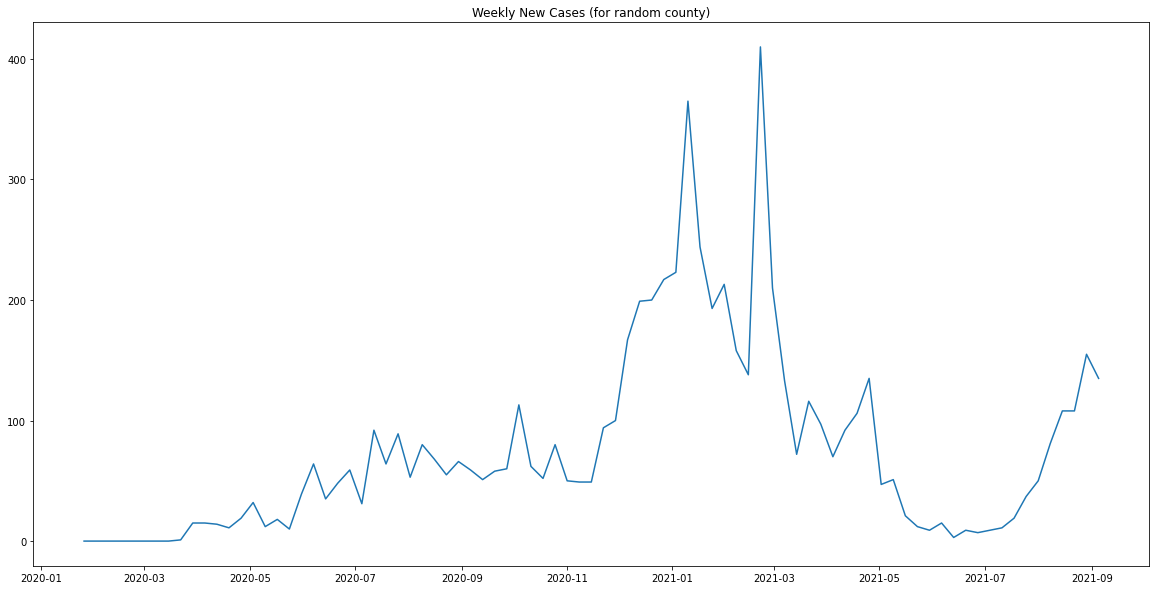

In [15]:
# Let's sum up new cases per week to be less erratic
albemarle_weekly = albemarle.set_index('date').resample('W')['cases_new'].sum().reset_index()
plt.figure(figsize=(20,10))
plt.title('Weekly New Cases (for random county)')
plt.plot(albemarle_weekly['date'], albemarle_weekly['cases_new'])

# Meh, outlier still dictates the curve's peak value

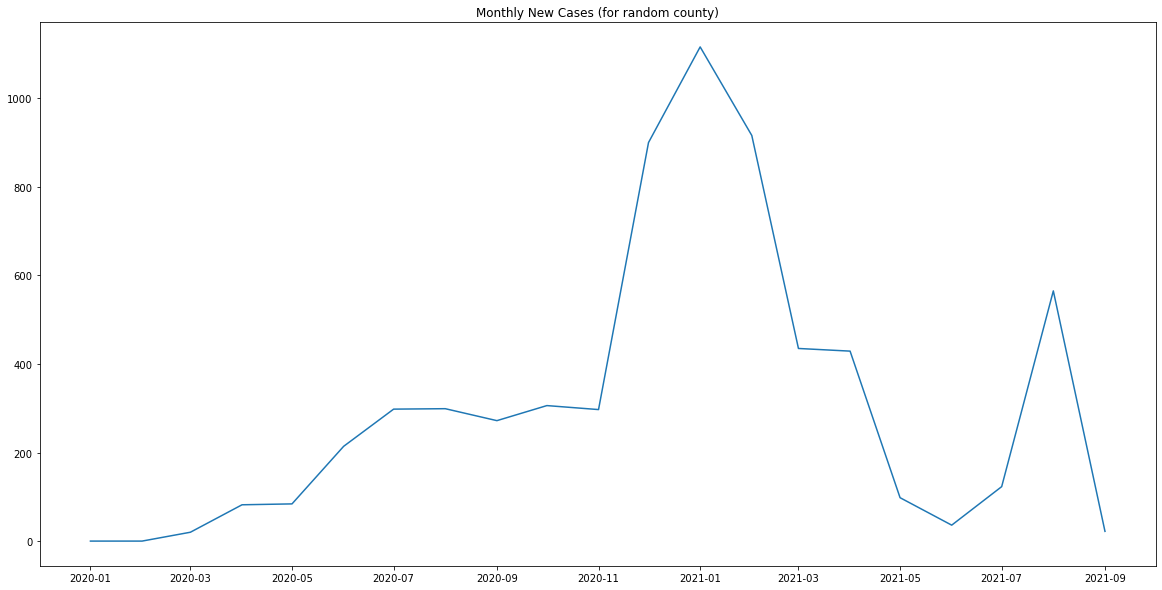

In [16]:
# Let's also look at monthly grouping
albemarle_monthly = albemarle.set_index('date').resample('MS')['cases_new'].sum().reset_index()
plt.figure(figsize=(20,10))
plt.title('Monthly New Cases (for random county)')
plt.plot(albemarle_monthly['date'], albemarle_monthly['cases_new'])

# Peak is correct, but I imagine the monly timescale is not granular enough

In [17]:
# Let's look at several county curves for new cases summed over each month


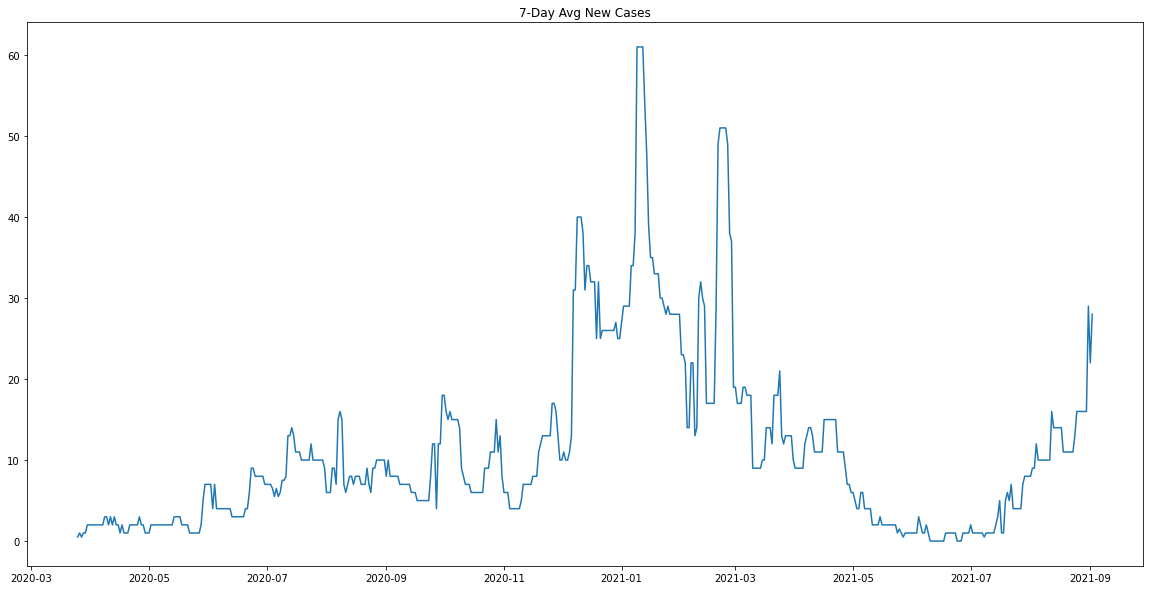

In [18]:
# Let's look at a rolling 7-day median of new case counts, which minimizes outlier reports
albemarle_rolling = albemarle.set_index('date').rolling(7, min_periods=4)['cases_new'].median()
plt.figure(figsize=(20,10))
plt.title('7-Day Avg New Cases')
plt.plot(albemarle_rolling.index, albemarle_rolling)

# bingo... will explore further and update persistent county features below

### Realize using something derived from case count to predict case count is biased

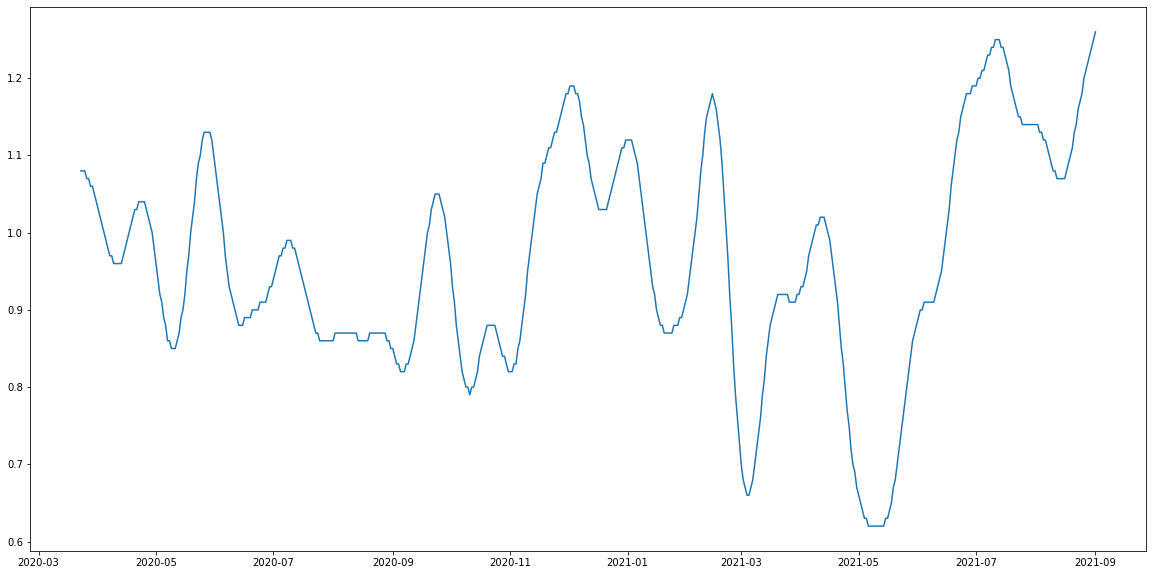

In [19]:
# Look at infection rate: estimated number of infections arising from a typical case
plt.figure(figsize=(20,10))
plt.plot(albemarle['date'], albemarle['infection_rate'])

# This is already a derived quantity and it looks a bit of a mess... don't think I'll use this

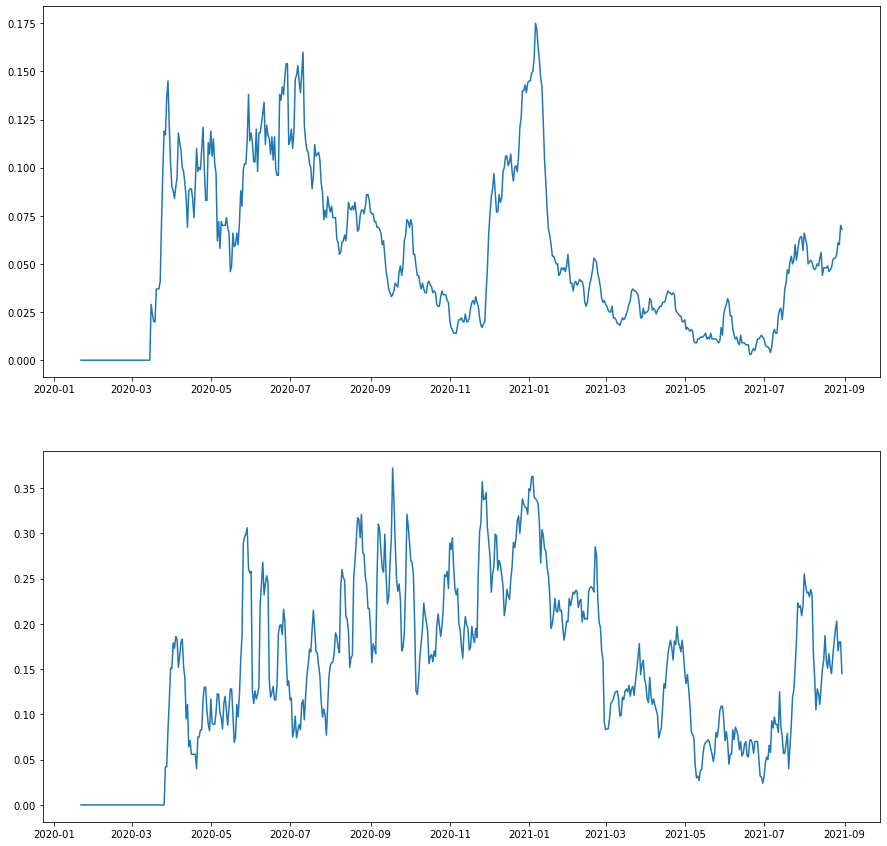

In [20]:
# And test positivity ratio: ratio of people who test positive calculated using a 7-day rolling average.
# Compare 2 counties with unlike vaccination rates: Albemarle, VA and Prince George, VA
princegeorge = candata[(candata['state']=='VA') & (candata['county']=='Prince George County')]
fig, axs = plt.subplots(2, 1, figsize=(15,15))
axs[0].plot(albemarle['date'], albemarle['test_positivity'])
axs[1].plot(princegeorge['date'], princegeorge['test_positivity'])

# There's probably something here, particularly if smoothed it or grouped into weeks

In [21]:
candata

,date,state,county,fips,cases_total,cases_new,deaths_total,deaths_new,vaccination_rate,test_positivity,infection_rate
0,2020-01-22,AK,Aleutians East Borough,02013,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-23,AK,Aleutians East Borough,02013,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-24,AK,Aleutians East Borough,02013,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-25,AK,Aleutians East Borough,02013,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-26,AK,Aleutians East Borough,02013,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1885508,2021-08-29,WY,Weston County,56045,773.0,0.0,6.0,0.0,0.27,0.222,0.89
1885509,2021-08-30,WY,Weston County,56045,775.0,2.0,6.0,0.0,0.27,0.246,0.87
1885510,2021-08-31,WY,Weston County,56045,780.0,5.0,6.0,0.0,0.27,NaN,0.85
1885511,2021-09-01,WY,Weston County,56045,789.0,9.0,6.0,0.0,0.27,NaN,0.84


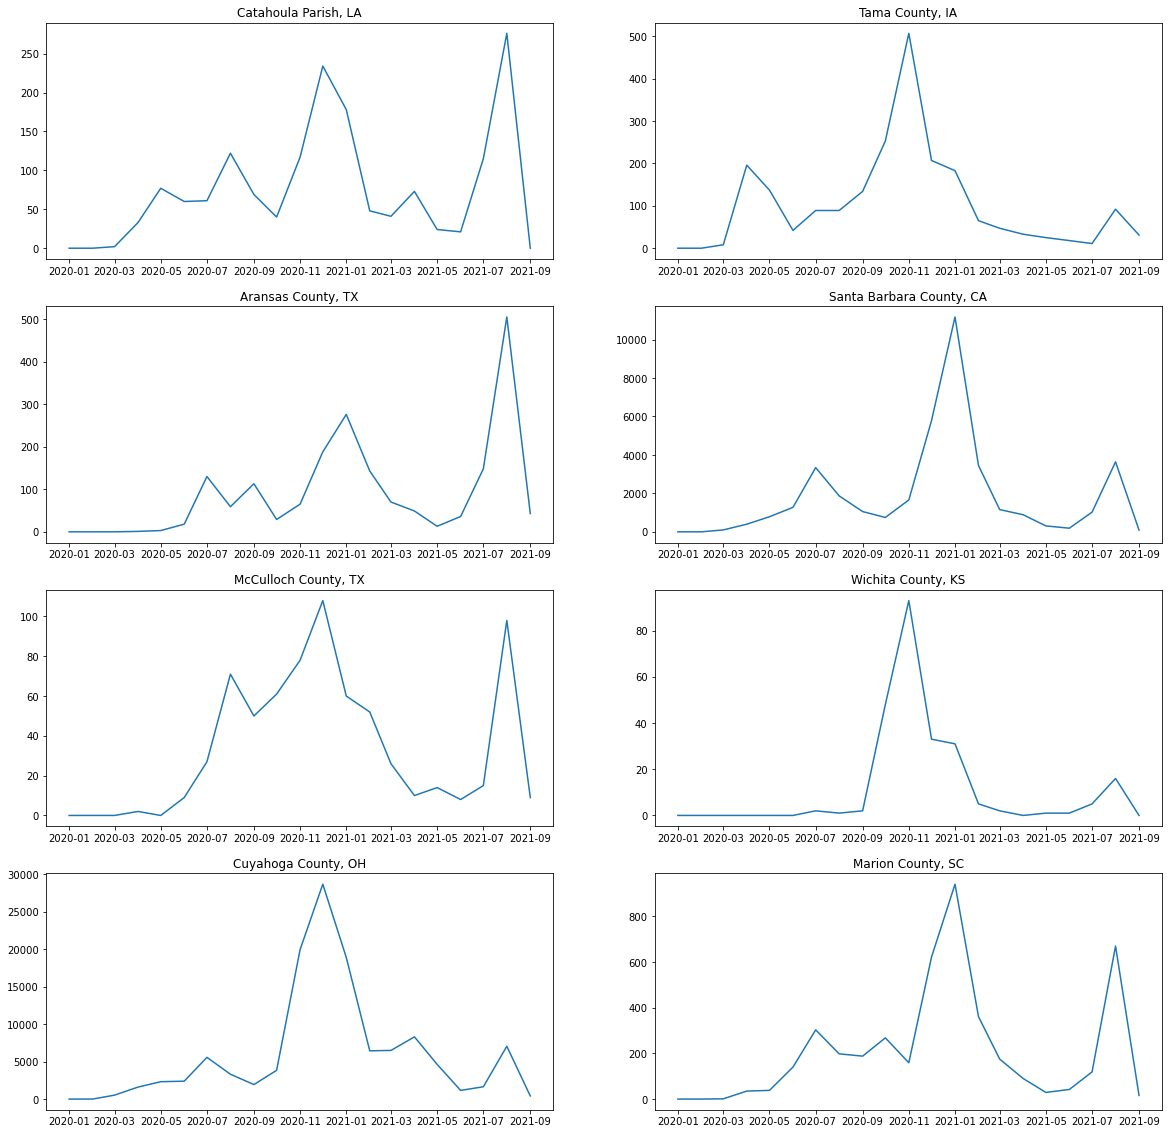

In [22]:
# Going back to monthly new case totals per county, let's look at a group of random counties
rnd_counties = np.random.choice(candata['fips'].unique(), size=8, replace=False)
fig, axs = plt.subplots(4, 2, figsize=(20,20))
county_itr = iter(rnd_counties)
for y in np.arange(axs.shape[0]):
    for x in np.arange(axs.shape[1]):
        fips = next(county_itr)
        co = candata[candata['fips']==fips]
        county, state = co['county'].iloc[0], co['state'].iloc[0]
        co = co.set_index('date').resample('MS')['cases_new'].sum().reset_index()
        axs[y,x].set_title(f'{county}, {state}')
        axs[y,x].plot(co['date'], co['cases_new'])

# Grasping at straws here, but I'm wondering if the ratio of peak monthly case counts before 2020-09 to after 2020-09 
# can predict the vaccination rate. This follows the notion that a higher ratio indicates a county's willingness to adopt
# lifestyle changes to reduce disease transmission. This value will be added to static county dataframe below.

In [23]:
if os.path.exists('../../pickles/CANpickles/candata.pkl'):
    os.remove('../../pickles/CANpickles/candata.pkl')
candata.to_pickle('../../pickles/CANpickles/candata.pkl')

## Static County Data
We want to look at some static county features

In [24]:
## Create a roll up of data per county (removing timeseries, removing non-continental counties)
non_continental_states = ['AK', 'HI', 'MP', 'GU', 'VI', 'PR', 'AS']
candata_county = candata[~candata['state'].isin(non_continental_states)]
candata_county = candata_county.groupby('fips')[['cases_total', 'deaths_total', 'vaccination_rate']].max()
candata_county['infection_rt'] = candata.groupby('fips')['infection_rate'].last()
candata_county.columns = ['cases', 'deaths', 'vaccination_rate', 'infection_rate']
candata_county.index.name = 'FIPS'

In [25]:
# Add peak montly new cases ratio -- greatest monthly total from pre-Sep 2020 over post-Sep 2020 -- as described above
# First though, confirm function works with Deleware's three counties
def get_case_peak_ratio(county_df):
    monthly_totals = county_df.set_index('date').resample('MS')['cases_new'].sum()
    pre_max = monthly_totals.loc[:'2020-09-01'].max()
    post_max = monthly_totals.loc['2020-09-01':].max()
    return pre_max / post_max if post_max>0 else np.nan

candata[candata['state']=='DE'].groupby('fips').apply(get_case_peak_ratio)

fips
10001    0.178133
10003    0.164913
10005    0.367403
dtype: float64

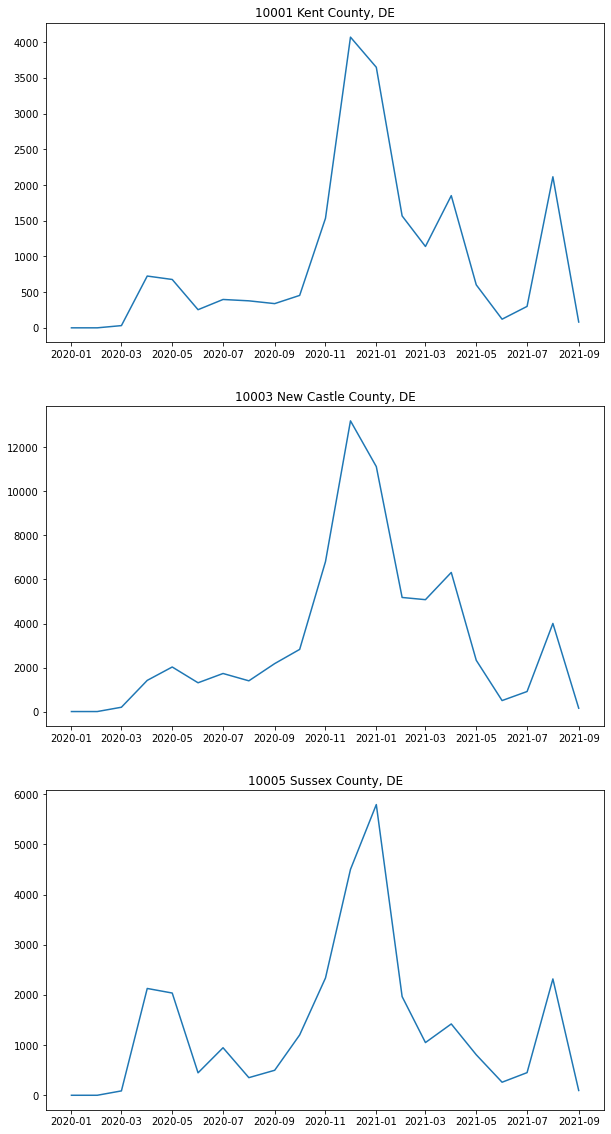

In [26]:
# And now plot monthly new case graphs for Deleware's counties 
de_counties = candata[candata['state']=='DE']['fips'].unique()
fig, axs = plt.subplots(3, 1, figsize=(10,20))
county_itr = iter(de_counties)
for y in np.arange(axs.shape[0]):
    fips = next(county_itr)
    co = candata[candata['fips']==fips]
    county, state = co['county'].iloc[0], co['state'].iloc[0]
    co = co.set_index('date').resample('MS')['cases_new'].sum().reset_index()
    axs[y].set_title(f'{fips} {county}, {state}')
    axs[y].plot(co['date'], co['cases_new'])
    
# Calculated ratios for Deleware's three counties look correct when eyeballing that ratio from the graphs of monthly case totals

In [27]:
# Create case peak ratio for all counties
candata_county['case_peak_ratio'] = candata.groupby('fips').apply(get_case_peak_ratio)

In [28]:
# Do any counties have NaN for case peak ratio? This would mean they had zero case count after Sep 2020.
candata_county['case_peak_ratio'].isna().sum()

# Yes, 12 of them... we'll have to filter them out

12

In [29]:
candata_county = candata_county[~candata_county['case_peak_ratio'].isna()]

In [30]:
candata_county['case_peak_ratio'].describe()

count    3096.000000
mean        0.286406
std         0.231556
min         0.000000
25%         0.134716
50%         0.232756
75%         0.376046
max         2.820789
Name: case_peak_ratio, dtype: float64

In [31]:
# How many counties have case ratio of zero... implying no cases logged before September 2020?
candata_county[candata_county['case_peak_ratio']==0.0].shape

(90, 5)

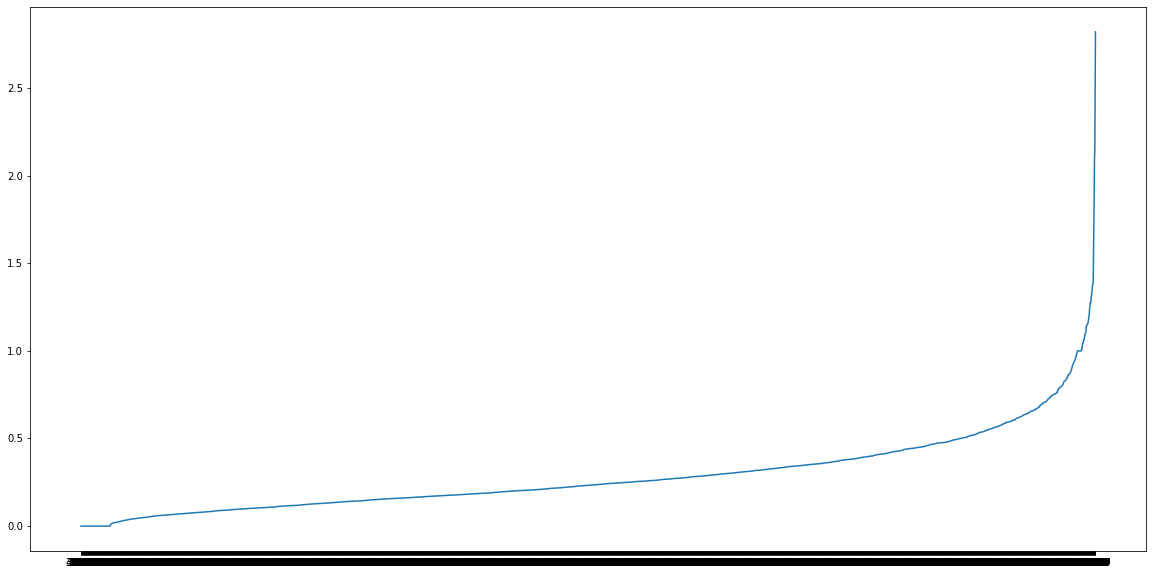

In [32]:
plt.figure(figsize=(20,10))
plt.plot(candata_county['case_peak_ratio'].sort_values())

In [33]:
# Let's just drop the counties where case ratio is zero too... probably cases weren't reported before Sep 2020
candata_county = candata_county[~(candata_county['case_peak_ratio']==0.0)]
candata_county.shape

# new row count checks out (original 3108 counties, less 12 with no cases after 2020-09, less 90 with no cases before 2020-09)

(3006, 5)

In [34]:
# More important than the ration of peak new case counts could be the ratio of total cases before Sep 2020 (waves 1 and 2) to afterwards
# Let's actually limit the denominator to cases before the alpha varaint (wave 3) and widespread vaccine availability, i.e., through May 2021
# May as well capture the post-May 2021 total cases (wave 4) too

# First, capture total cases for each of the three identified timeframes
candata_county['cases_w1_w2'] = candata.groupby('fips').apply(lambda county: county.set_index('date').loc[:'2020-09-01']['cases_new'].sum())
candata_county['cases_w3'] = candata.groupby('fips').apply(lambda county: county.set_index('date').loc['2020-09-01':'2021-06-01']['cases_new'].sum())
candata_county['cases_w4'] = candata.groupby('fips').apply(lambda county: county.set_index('date').loc['2021-06-01':]['cases_new'].sum())

In [35]:
candata_county.isna().sum()

# No empty case totals, good

cases                 0
deaths                0
vaccination_rate      5
infection_rate      171
case_peak_ratio       0
cases_w1_w2           0
cases_w3              0
cases_w4              0
dtype: int64

In [36]:
# Then the case total ratio
candata_county['case_total_ratio'] = candata_county['cases_w1_w2'] / candata_county['cases_w3']

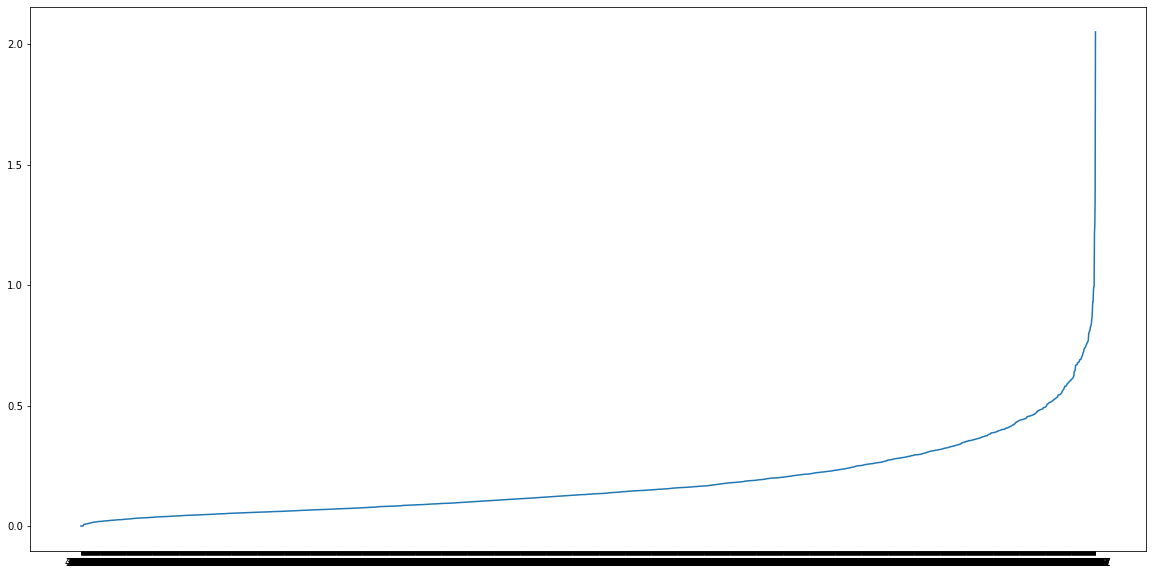

In [37]:
plt.figure(figsize=(20,10))
plt.plot(candata_county['case_total_ratio'].sort_values())

In [38]:
# Bring in previously processed geographic county data
counties_raw = pd.read_pickle('../../pickles/counties.pkl')

In [39]:
# Find each county's neighboring counties
counties_raw['neighbors'] = counties_raw.apply(lambda row: counties_raw[counties_raw.touches(row['geometry'])].index.to_numpy(), axis=1)

In [40]:
counties_raw

,state_name,county_name,area,geometry,pop,density,neighbors
FIPS,,,,,,,
21141,Kentucky,Logan,1430224002,"POLYGON ((-87.06037 36.68085, -87.06002 36.708...",27102,18.949479,"[47147, 21031, 21177, 21227, 21219, 21213]"
36081,New York,Queens,281594050,"POLYGON ((-73.96262 40.73903, -73.96243 40.739...",2253858,8003.926219,"[36005, 36059, 36061, 36047]"
34017,New Jersey,Hudson,119640822,"MULTIPOLYGON (((-74.04220 40.69997, -74.03900 ...",672391,5620.080076,"[34039, 34013, 36061, 34003, 36085]"
34019,New Jersey,Hunterdon,1108086284,"POLYGON ((-75.19511 40.57969, -75.19466 40.581...",124371,112.239454,"[34027, 34041, 34035, 42017, 34021]"
21147,Kentucky,McCreary,1105416696,"POLYGON ((-84.77845 36.60329, -84.73068 36.665...",17231,15.587787,"[21125, 47013, 47151, 21231, 21199, 21235]"
...,...,...,...,...,...,...,...
08014,Colorado,Broomfield,85386686,"MULTIPOLYGON (((-105.10667 39.95783, -105.1073...",70465,825.245753,"[08013, 08059, 08123, 08001]"
08121,Colorado,Washington,6521806795,"POLYGON ((-103.70655 39.73989, -103.70655 39.7...",4908,0.752552,"[08005, 08001, 08063, 08087, 08125, 08075, 08073]"
27037,Minnesota,Dakota,1456967786,"POLYGON ((-93.32967 44.77948, -93.32962 44.791...",429021,294.461555,"[27139, 27163, 27053, 55093, 27123, 27131, 27049]"


In [41]:
# Merge in candata county features... 
counties = counties_raw.merge(candata_county, how='left', left_index=True, right_index=True)
counties

,state_name,county_name,area,geometry,pop,density,neighbors,cases,deaths,vaccination_rate,infection_rate,case_peak_ratio,cases_w1_w2,cases_w3,cases_w4,case_total_ratio
FIPS,,,,,,,,,,,,,,,,
21141,Kentucky,Logan,1430224002,"POLYGON ((-87.06037 36.68085, -87.06002 36.708...",27102,18.949479,"[47147, 21031, 21177, 21227, 21219, 21213]",4009.0,77.0,0.412,1.10,0.205368,455.0,2468.0,1129.0,0.184360
36081,New York,Queens,281594050,"POLYGON ((-73.96262 40.73903, -73.96243 40.739...",2253858,8003.926219,"[36005, 36059, 36061, 36047]",291367.0,10052.0,0.653,0.94,0.728251,70158.0,201133.0,20050.0,0.348814
34017,New Jersey,Hudson,119640822,"MULTIPOLYGON (((-74.04220 40.69997, -74.03900 ...",672391,5620.080076,"[34039, 34013, 36061, 34003, 36085]",92750.0,2346.0,0.610,0.91,0.960317,20210.0,65606.0,4865.0,0.308051
34019,New Jersey,Hunterdon,1108086284,"POLYGON ((-75.19511 40.57969, -75.19466 40.581...",124371,112.239454,"[34027, 34041, 34035, 42017, 34021]",10738.0,180.0,0.585,1.03,0.289308,1215.0,8171.0,963.0,0.148697
21147,Kentucky,McCreary,1105416696,"POLYGON ((-84.77845 36.60329, -84.73068 36.665...",17231,15.587787,"[21125, 47013, 47151, 21231, 21199, 21235]",2563.0,35.0,0.328,1.31,0.150974,102.0,1941.0,572.0,0.052550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
08014,Colorado,Broomfield,85386686,"MULTIPOLYGON (((-105.10667 39.95783, -105.1073...",70465,825.245753,"[08013, 08059, 08123, 08001]",5646.0,78.0,0.683,1.03,0.142564,541.0,4349.0,776.0,0.124396
08121,Colorado,Washington,6521806795,"POLYGON ((-103.70655 39.73989, -103.70655 39.7...",4908,0.752552,"[08005, 08001, 08063, 08087, 08125, 08075, 08073]",487.0,13.0,0.246,1.02,0.259542,52.0,427.0,26.0,0.121780
27037,Minnesota,Dakota,1456967786,"POLYGON ((-93.32967 44.77948, -93.32962 44.791...",429021,294.461555,"[27139, 27163, 27053, 55093, 27123, 27131, 27049]",50075.0,487.0,0.567,1.14,0.180888,5972.0,40655.0,3490.0,0.146895


In [42]:
if os.path.exists('../../pickles/CANpickles/cancounties.pkl'):
    os.remove('../../pickles/CANpickles/cancounties.pkl')
counties.to_pickle('../../pickles/CANpickles/cancounties.pkl')

In [43]:
counties['infection_rate'].describe()

count    2835.000000
mean        1.076991
std         0.196956
min         0.350000
25%         0.960000
50%         1.080000
75%         1.200000
max         2.290000
Name: infection_rate, dtype: float64

<AxesSubplot:>

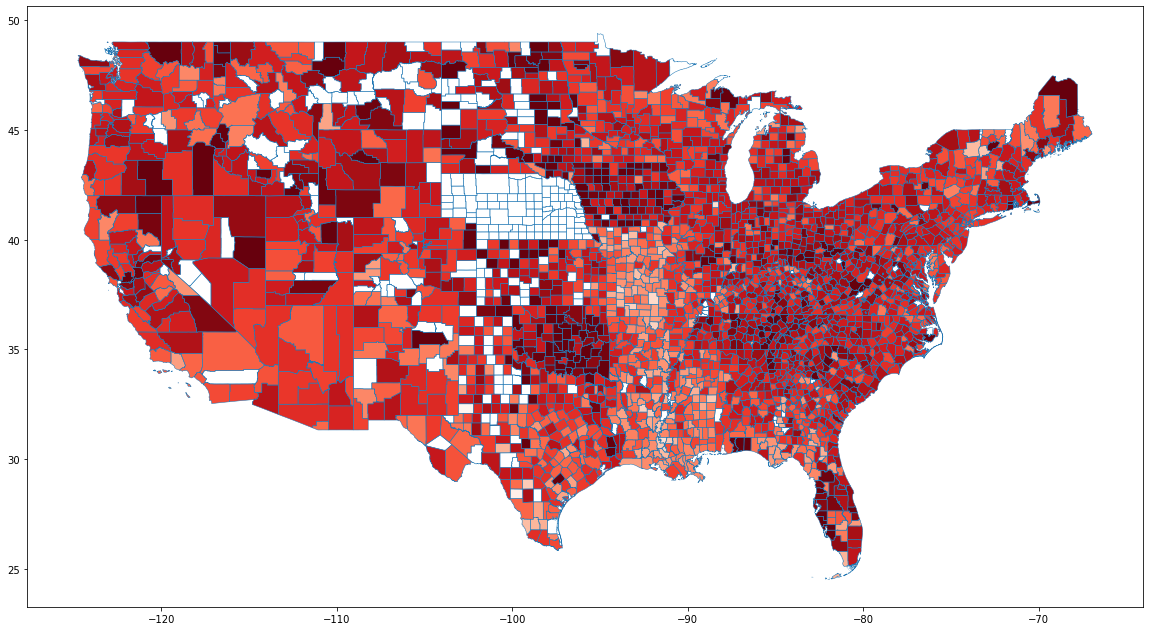

In [44]:
base = counties.boundary.plot(figsize=(20,20), linewidth=0.5)
counties.plot(counties['infection_rate'], cmap='Reds', vmax=1.38, ax=base)

In [45]:
(counties['cases']/counties['pop']).describe()

count    3006.000000
mean        0.123183
std         0.033633
min         0.014560
25%         0.102364
50%         0.124130
75%         0.143240
max         0.466856
dtype: float64

<AxesSubplot:>

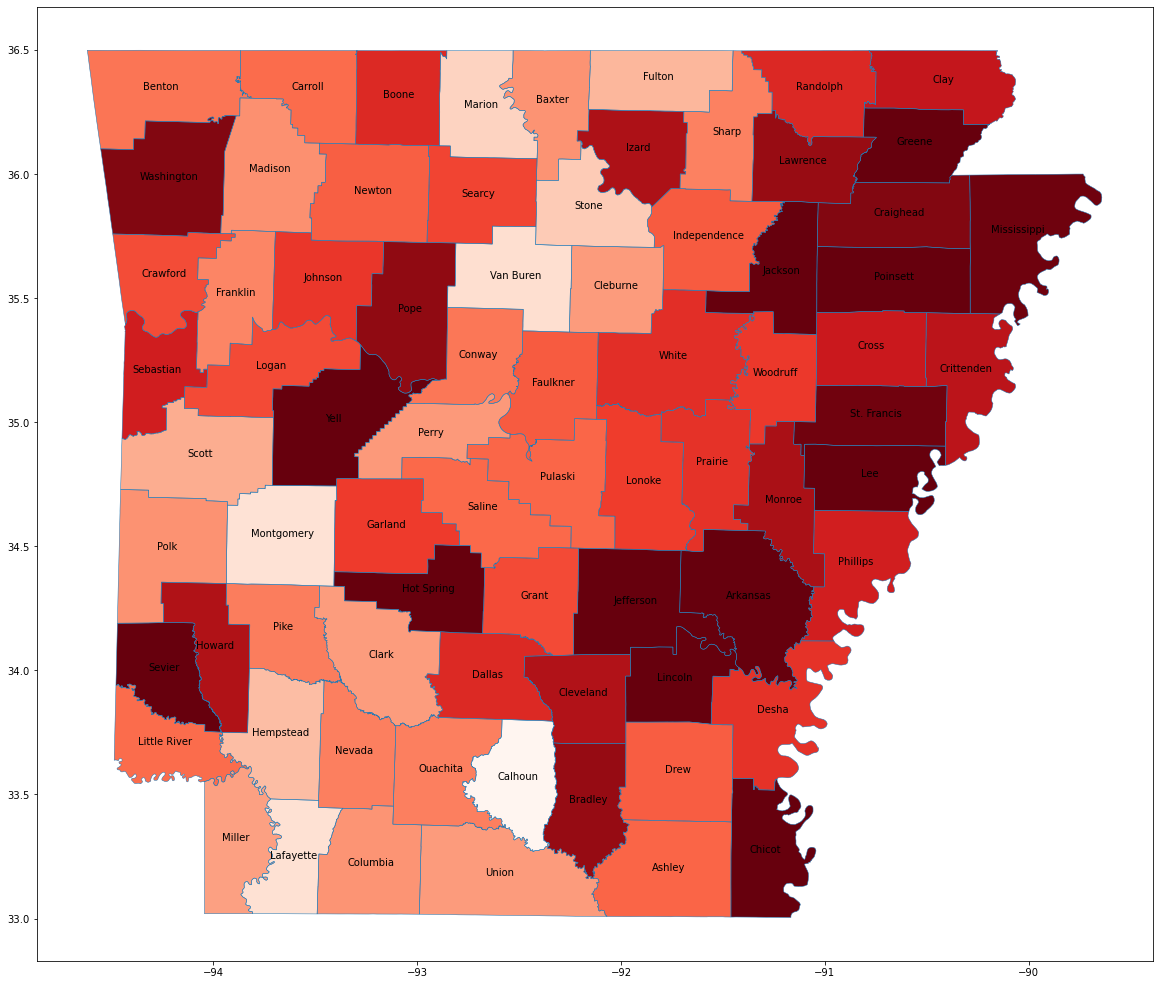

In [46]:
arkansas = counties[counties['state_name']=='Arkansas']
base = arkansas.boundary.plot(figsize=(20,20), linewidth=0.5)
arkansas.apply(lambda x: base.annotate(text=x['county_name'], xy=x['geometry'].centroid.coords[0], ha='center'), axis=1)
arkansas.plot(arkansas['cases']/arkansas['pop'], cmap='Reds', vmax=0.1725, ax=base)

<AxesSubplot:>

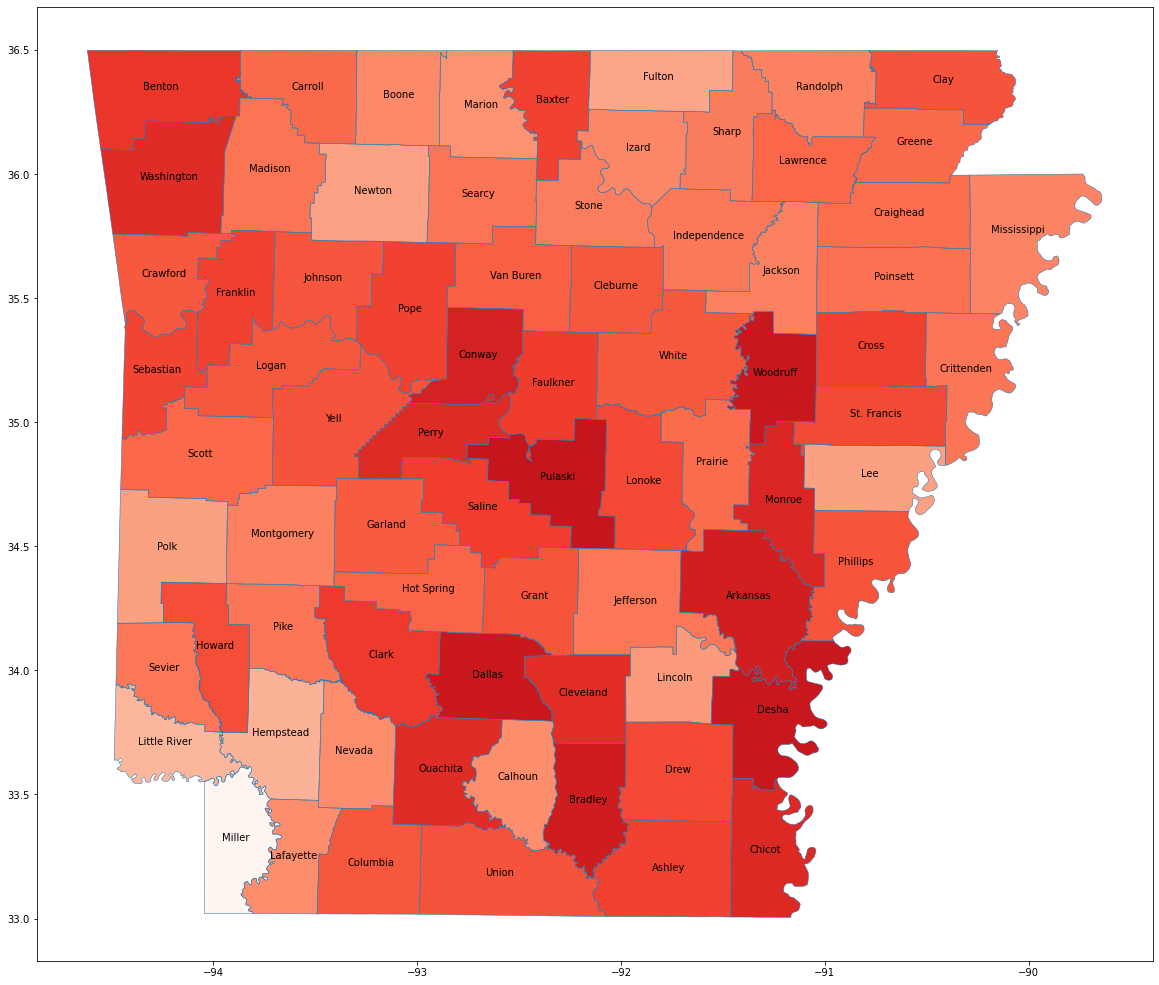

In [47]:
base = arkansas.boundary.plot(figsize=(20,20), linewidth=0.5)
arkansas.apply(lambda x: base.annotate(text=x['county_name'], xy=x['geometry'].centroid.coords[0], ha='center'), axis=1)
arkansas.plot(arkansas['vaccination_rate'], cmap='Reds', vmax=0.57, ax=base)

In [48]:
arkansas[['county_name', 'pop']].sort_values('pop').to_numpy()

array([['Calhoun', 5189],
       ['Woodruff', 6320],
       ['Lafayette', 6624],
       ['Monroe', 6701],
       ['Dallas', 7009],
       ['Newton', 7753],
       ['Searcy', 7881],
       ['Cleveland', 7956],
       ['Prairie', 8062],
       ['Nevada', 8252],
       ['Lee', 8857],
       ['Montgomery', 8986],
       ['Chicot', 10118],
       ['Scott', 10281],
       ['Perry', 10455],
       ['Pike', 10718],
       ['Bradley', 10763],
       ['Desha', 11361],
       ['Little River', 12259],
       ['Fulton', 12477],
       ['Stone', 12506],
       ['Lincoln', 13024],
       ['Howard', 13202],
       ['Izard', 13629],
       ['Clay', 14551],
       ['Lawrence', 16406],
       ['Cross', 16419],
       ['Van Buren', 16545],
       ['Madison', 16576],
       ['Marion', 16694],
       ['Jackson', 16719],
       ['Sevier', 17007],
       ['Sharp', 17442],
       ['Arkansas', 17486],
       ['Franklin', 17715],
       ['Phillips', 17782],
       ['Randolph', 17958],
       ['Drew', 18219],
   

<AxesSubplot:>

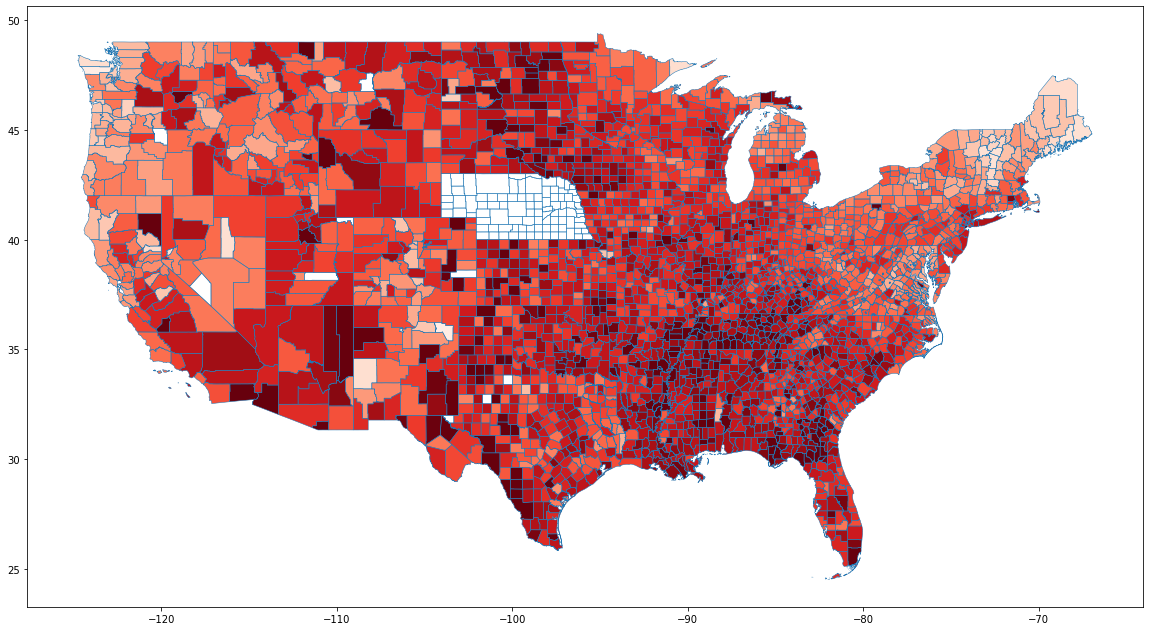

In [49]:
base = counties.boundary.plot(figsize=(20,20), linewidth=0.5)
# base.set_xlim([-95, -85])
# base.set_ylim([32, 38])
counties.plot(counties['cases']/counties['pop'], cmap='Reds', vmax=0.1725, ax=base)

In [50]:
counties['vaccination_rate'].describe()

count    3001.000000
mean        0.410864
std         0.106154
min         0.023000
25%         0.336000
50%         0.397000
75%         0.476000
max         0.834000
Name: vaccination_rate, dtype: float64

<AxesSubplot:>

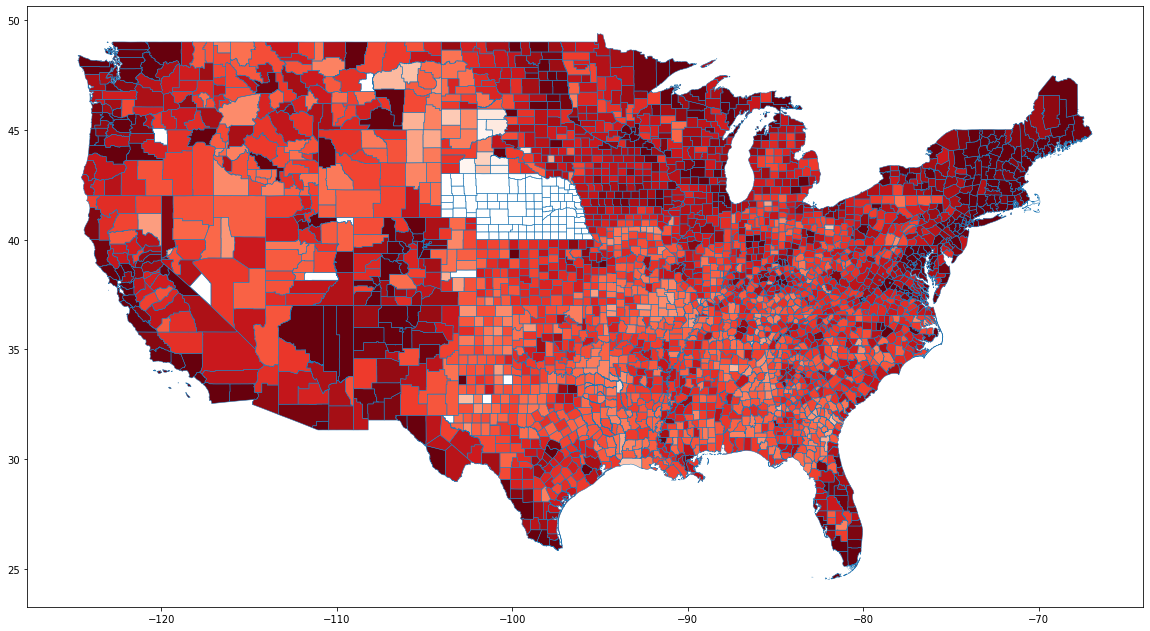

In [51]:
# Note: USA bounding box (long, lat): appr. -125 to -65, 25 to 50
base = counties.boundary.plot(figsize=(20,20), linewidth=0.5)
# base.set_xlim([-95, -85])
# base.set_ylim([32, 38])
counties.plot(counties['vaccination_rate'], cmap='Reds', vmax=.57, ax=base)

In [52]:
(counties['deaths']/counties['cases']).describe()

count    3006.000000
mean        0.018299
std         0.008805
min         0.000000
25%         0.012521
50%         0.016898
75%         0.022608
max         0.142857
dtype: float64

<AxesSubplot:ylabel='Frequency'>

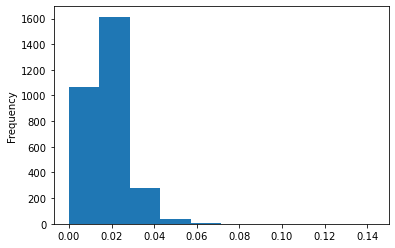

In [53]:
(counties['deaths']/counties['cases']).plot.hist()

<AxesSubplot:>

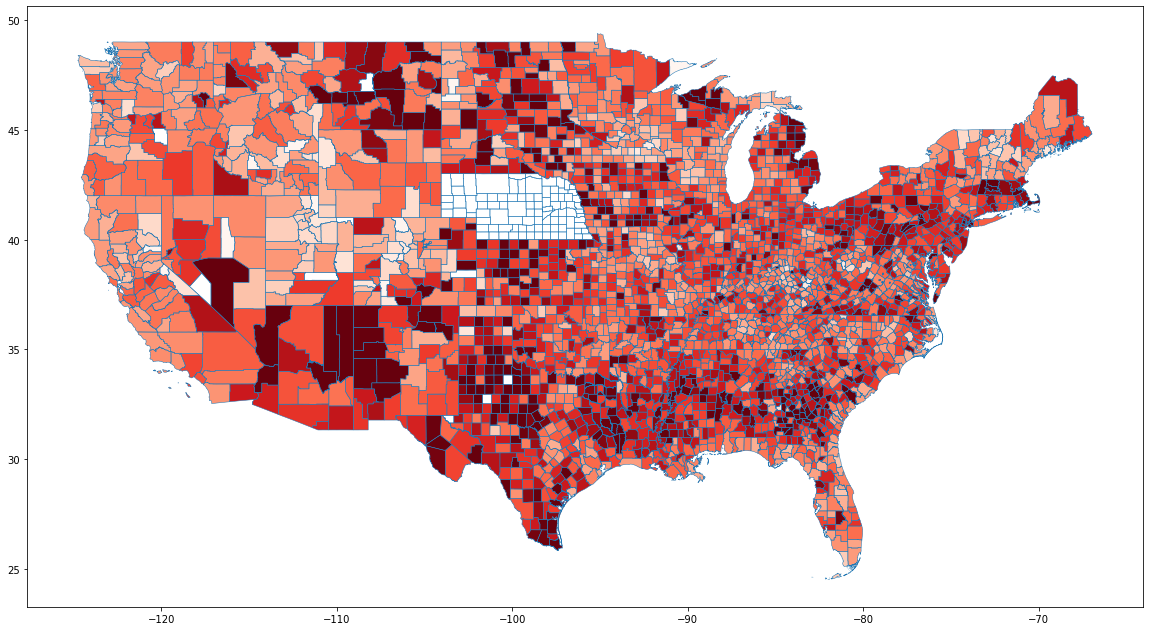

In [54]:
base = counties.boundary.plot(figsize=(20,20), linewidth=0.5)
counties.plot(counties['deaths']/counties['cases'], cmap='Reds', vmax=0.03, ax=base)

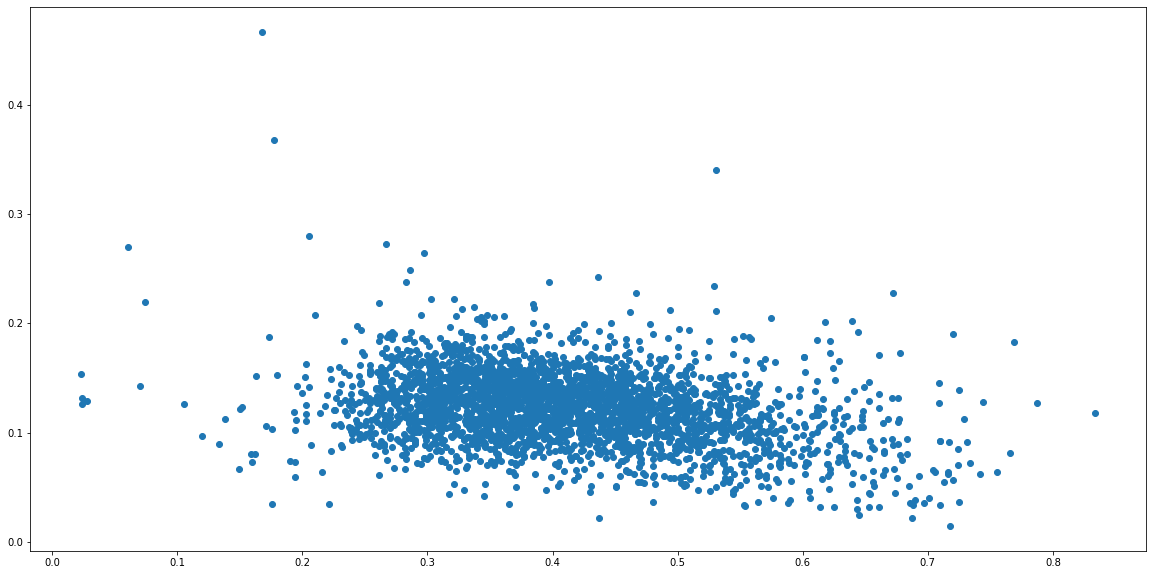

In [55]:
plt.figure(figsize=(20,10))
# plt.ylim(0.05, 0.20)
plt.scatter(counties['vaccination_rate'], (counties['cases']/counties['pop']))